# UK Car Sales: Data Preprocessing

__________________________
**Tags:** *Machine Learning*, *Data Preprocessing*, *Data Visualization*

**Techniques**: *Feature Engineering*, *Feature Transformation*, *Correlation Analysis*, *Imputation Methods*

**Python:** *pandas*, *scikit-learn*, *seaborn*
__________________________

__________________________
**Scenario:** In a previous step, we have collected data on a UK second-hand platform for used cars. As of now, the data is not yet ready for statistical learning purposes. In this notebook, we will prepare the data through various means in order for it to be processable by common Machine Learning algorithms.
__________________________

__________________________
## Contents

1. **Importing Data**
<p> </p>
2. **Handling Categorical Data**
<p> </p>
3. **Handling Numerical Data**
<p> </p>
4. **The Final Transformer**
<p> </p>
5. **Summary**
__________________________

# TO DO:

- Update Table of Contents
- delete last few lines
- Summary: what have we learned, correlation analyses, ...?
  + Bad news for XY drivers: worthless cars
  + car price extremely sensitive in the first two years
  + manual gear is not great  

### Relevant packages used throughout this notebook

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

<p> <br> </p>
<p> <br> </p>
<p> <br> </p>
<p> <br> </p>
<p> <br> </p>

__________________________
# 1. Importing Data

The following code imports the aggregated CSV data which it assumes to be stored in the current working directory.

In [2]:
import_path = os.getcwd() + "/all_cars.csv"
df_cars = pd.read_csv(import_path)
df_cars.shape

(108540, 10)

In [3]:
df_cars.head()

,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,audi,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4
1,audi,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0
2,audi,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4
3,audi,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0
4,audi,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0


As the following line shows, we are dealing with 6 numerical and 4 categorical features.

In [4]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   brand         108540 non-null  object 
 1   model         108540 non-null  object 
 2   year          108540 non-null  int64  
 3   price         108540 non-null  int64  
 4   transmission  108540 non-null  object 
 5   mileage       108540 non-null  int64  
 6   fuelType      108540 non-null  object 
 7   tax           99187 non-null   float64
 8   mpg           99187 non-null   float64
 9   engineSize    108540 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 8.3+ MB


### Ensuring reproducibility

In [5]:
rng = np.random.RandomState(314)

### Creating training and test set

In [6]:
df_train, df_test = train_test_split(df_cars, test_size=0.1, random_state=rng)

<p> <br> </p>
<p> <br> </p>
<p> <br> </p>

__________________________
# 2. Handling Categorical Data

Since there are only 4 categorical features present, let us take a quick look at the categorical training data.

In [7]:
df_train.describe(include=object)

,brand,model,transmission,fuelType
count,97686,97686,97686,97686
unique,11,195,4,5
top,ford,Focus,Manual,Petrol
freq,16202,9011,55231,53824


It should not be a problem to one-hot encode the features *brand*, *transmission* and *fuelType* as this will not create many additional features. However, encoding 195 different model types in this way is not viable. We will instead store the average sale price observed in the training data for each model in a separate column. Let us create the respective data pipelines.

### One-Hot Encoding Pipeline
**(for features *brand*, *transmission*, *fuelType*)**

In [8]:
onehot_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

### Average Model Price Transformer and Pipeline
**(for feature *model*)**

The following class creates a custom Scikit transformer. It is passed a dataframe and the name of the respective columns for the model type and the price, as it is observable in the training data. It then replaces the model feature by creating a new variable containing instead the average price for each particular model in the dataset. This way, the feature is much easier to handle and we hence omit the problem of having to store roughly 200 different categorical attributes in a dataset.

In [9]:
class AverageModelPrice(BaseEstimator, TransformerMixin):
    """
    Custom Feature Transformer. For a transformer to work with scikit-learn,
    it has to include three methods: 'fit()', 'transform()', 'fit_transform()'.    
    
    For each observed model, this transformer computes the average sale price for each model 
    present in the given training set. It stores this value in the model column. The 
    respective column names must be passed when initializing a transformer object.
    
    From BaseEstimator, the methods 'get_params()' and 'set_params()' are inherited.
    From TransformerMixin, the method 'fit_transform()' is inherited.
    """
    
    def __init__(self, model_col, price_col):
        self.price_dict_ = dict() #dictionary to store learned prices
        self.model_col = model_col #name of the model column
        self.price_col = price_col #name of the price column
    
    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = X.columns
        
        #collecting all model names from the training data
        self.model_list_ = X[self.model_col].unique()
        
        #adding average model prices to dictionary
        for model_name in self.model_list_:
            self.model_price_ = X[X[self.model_col] == model_name][self.price_col].mean()
            self.price_dict_[model_name] = self.model_price_
        return self
    
    def transform(self, X):
        X.loc[:, self.model_col] = X[self.model_col].map(self.price_dict_).astype(float)
        return X[[self.model_col]]
    
    def get_feature_names_out(self):
        return np.array([self.model_col])

In [10]:
#Creating Transformer Instance specifying column names
avgmodprc = AverageModelPrice(model_col="model", price_col="price")

#Creating respective Pipeline
model_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("avg", avgmodprc),
    ("stdscl", StandardScaler()) 
])

<p> <br> </p>
<p> <br> </p>
<p> <br> </p>

__________________________
# 3. Handling Numerical Data

Let us now consider the remaining six numerical features. We begin by checking the price correlations of all numerical features.

In [11]:
corr_price = df_train.select_dtypes("number").corr()["price"]
np.abs(corr_price).sort_values(ascending=False)

price         1.000000
engineSize    0.630269
year          0.496978
mileage       0.426944
tax           0.307522
mpg           0.297358
Name: price, dtype: float64

Luckily, all features are at least moderately relevant for price regression, but even if this would not have been the case, we could have kept them all as there are not many features present in the first place. As the full correlation matrix shows, most of the regressors do not correlate much amongst each other, which eliminates the risk of redundancy:

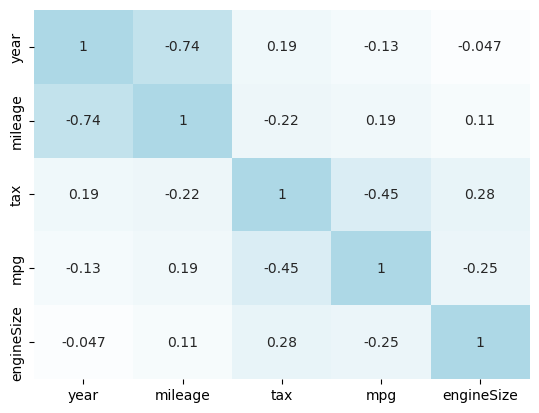

In [12]:
#creating a custom color map for correlation matrix so that values are colored according to their absolute value
cmap = LinearSegmentedColormap.from_list('WarmCoolWarm', ['lightblue', 'white', 'lightblue'])

corrmat = df_train[["year", "mileage", "tax", "mpg", "engineSize"]].corr()
sns.heatmap(corrmat, annot=True, cmap=cmap, cbar=False, vmin=-1, vmax=1, center=0)
plt.show()

### Price

As we will see below, the *price* feature appears to be right-skewed which is not ideal for most Machine learning algorithms.

In [13]:
#Setting general layout for seaborn plots
sns.set(style="darkgrid")
plt.rcParams["font.family"] = "Noto Sans"
title_font = {'fontsize': 13, 'fontname': 'Noto Sans'}

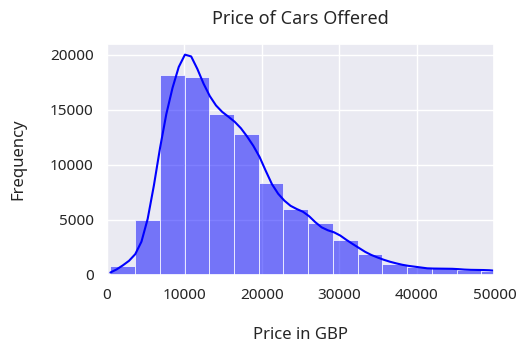

In [14]:
#Plotting price feature
plt.figure(figsize=(5, 3))

sns.histplot(df_train["price"], bins=50, kde=True, color="blue")
plt.title("Price of Cars Offered", y=1.05, **title_font)
plt.xlabel("\nPrice in GBP")
plt.ylabel("Frequency\n")
plt.xlim(0, 50000)
plt.ylim(0, 21000)

plt.show()

A logarithmic transformation yields a sufficiently adequate transformation:

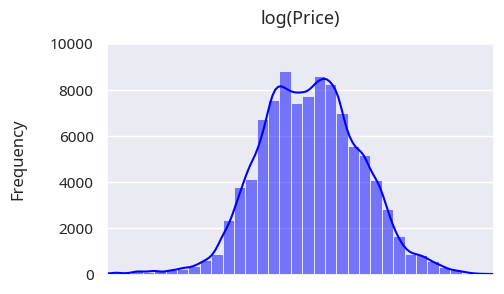

In [15]:
plt.figure(figsize=(5, 3))

sns.histplot(np.log(df_train["price"]), bins=50, kde=True, color="blue")
plt.title("log(Price)", y=1.05, **title_font)
plt.xlabel("")
plt.ylabel("Frequency\n")
plt.xticks(np.arange(6,13))
plt.xlim(7.5, 11.5)
plt.ylim(0, 10000)
plt.xticks([])

plt.show()

In [16]:
np.log(df_train["price"]).skew()

-0.13009446319180154

The corresponding transformer is easy to implement. Since we want to predict the price of the cars, it is important for the inverse function to mathematically exist and to be explicitly passed to the transformer:

In [17]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)

Lastly, we would like our data pipeline to impute missing values and to scale the new features to follow a standard normal distribution.

In [18]:
log_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="mean")),
    ("log", log_transformer),
    ("stdscl", StandardScaler()) 
])

### Mileage

The highest correlation between numerical variables is between *mileage* and *year*, which is not very surprising. Nevertheless, it could make sense to combine both features into a new one that instead measures a car's "wearout" over time. Instead of using the absolute mileage value, let us compute the average mileage per year and keep both this new feature and the year feature. After all, two cars with a mileage of 100000+ can be worth a very different amount depending on how long they have been in use.

In [19]:
class AverageMileage(BaseEstimator, TransformerMixin):
    """
    For each observed car, this transformer computes the average mileage per year.
    It stores this value in the mileage column. The respective column names must be 
    passed when initializing a transformer object.
    
    From BaseEstimator, the methods 'get_params()' and 'set_params()' are inherited.
    From TransformerMixin, the method 'fit_transform()' is inherited.
    """
    
    def __init__(self, mileage_col, year_col):
        self.mileage_col = mileage_col     #name of the mileage column
        self.year_col = year_col           #name of the year column
    
    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = X.columns
        return self
    
    def transform(self, X):
        #calculating age of cars
        #dataset was collected in 2020
        X.loc[:, self.mileage_col] = X[self.mileage_col] / (2021 - X[self.year_col])
        return X[[self.mileage_col]]
    
    def get_feature_names_out(self):
        return np.array([self.mileage_col])

We could create a pipeline now, but we are not done yet. Let us first plot the new variable to check its usefulness:

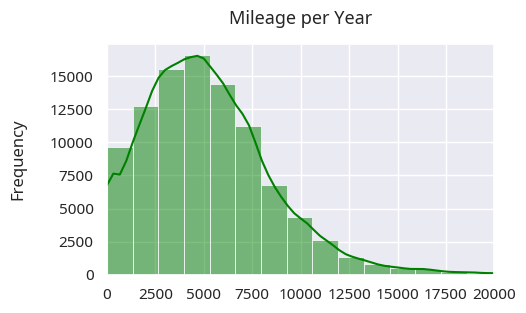

In [20]:
avgmil = AverageMileage(mileage_col="mileage", year_col="year")
mil_tf = avgmil.fit_transform(df_train[["mileage", "year"]])

plt.figure(figsize=(5,3))

sns.histplot(mil_tf["mileage"], bins=50, kde=True, color="green")
plt.title("Mileage per Year", y=1.05, **title_font)
plt.xlabel("")
plt.ylabel("Frequency\n")
plt.xlim(0, 20000)
plt.show()

In [21]:
mil_tf["mileage"].skew()

1.2407777840685665

This does not look optimal: we can clearly see a heavy tail on the right side of the distribution, the data is skewed. By raising each instance value to a power $p \in (0, 1)$, we can alleviate this. Trial and error gives a good result for $p = 0.5$, i.e. the square root:

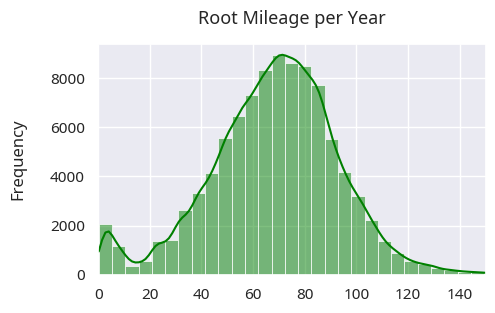

In [22]:
plt.figure(figsize=(5,3))

sns.histplot(np.power(mil_tf["mileage"], 0.5), bins=50, kde=True, color="green")
plt.title("Root Mileage per Year", y=1.05, **title_font)
plt.xlabel("")
plt.ylabel("Frequency\n")
plt.xlim(0,150)
plt.show()

In [23]:
np.power(mil_tf["mileage"], 0.5).skew()

-0.21535104121312526

What about missing values? In the current dataset, there are no missing values in these features, but we have to prepare for them anyway. For this reason, let us simply consider a car's k-nearest neighbors. Lastly, we need to scale the values to a standard normal distribution. The final mileage pipeline looks like this:

In [24]:
milimp = KNNImputer(n_neighbors=5)
root_transformer = FunctionTransformer(lambda x: np.power(x, 0.5), inverse_func=lambda y: np.power(y, 2))

#Creating Mileage Pipeline
mileage_pipeline = Pipeline([
    ("milimp", milimp),
    ("avgmil", avgmil),
    ("root", root_transformer),    
    ("stdscl", StandardScaler())
])

### Year

Let us take a look at the age of the observed cars by plotting a histogram.

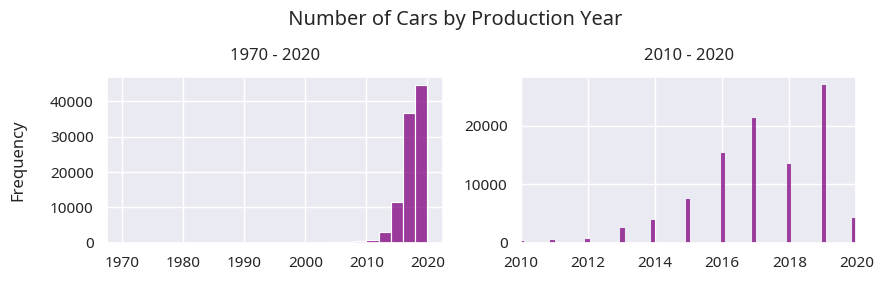

In [25]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
sns.histplot(df_train["year"], bins=25, color="purple")
plt.suptitle("     Number of Cars by Production Year", y=0.93)
plt.title("1970 - 2020", y=1.05)
plt.xlabel("")
plt.ylabel("Frequency\n")

plt.subplot(1, 2, 2)
sns.histplot(df_train["year"], color="purple")
plt.title("2010 - 2020", y=1.05)
plt.xlabel("")
plt.ylabel("")
plt.xlim(2010,2020)

plt.tight_layout()
plt.show()

(Note that in the left plot, the years are grouped in two, so the bars on the left correspond to the sum of two consecutive year values (e.g. 2019 and 2020), which is why the first plot reaches higher values than the right one.)

We can observe that the majority of cars are at most ten years old (the data has been collected in 2020). How does the age of the car influence its price on the market? A boxenplot can give us valuable insights. What we might have expected is that older cars are generally worth less. Additionally, we can see that there is a sharp drop in value after one year and again after two years. The subsequent drops in value are not as consequential. After six years of age (year 2014 and before), not only are there few cars left (about 9.0 %), but there is also not much value left to lose, as the following graph reveals:

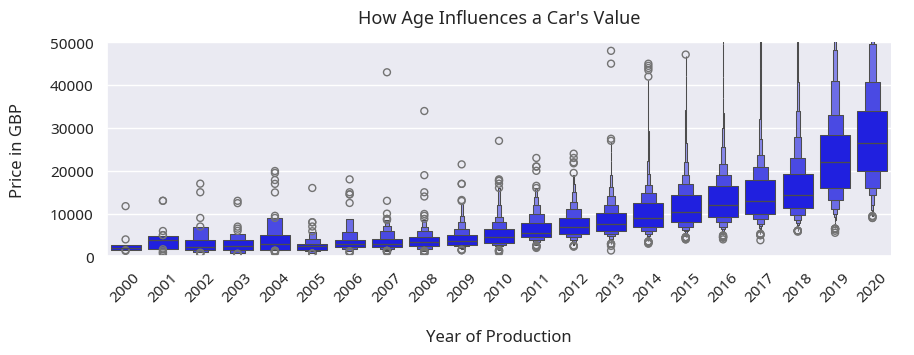

In [26]:
young_cars = df_train[df_train["year"] >= 2000]

sns.catplot(data=young_cars, y="price", x="year", color="blue", kind="boxen", 
                height=3, aspect=3)

plt.title("How Age Influences a Car's Value", y=1.05, **title_font)
plt.xticks(rotation=45)
plt.xlabel("\nYear of Production")
plt.ylabel("Price in GBP\n")
plt.ylim(0,50000)

plt.show()

For these reasons, it makes sense to keep the high values of the *year* feature as they are. On the other hand, it should not matter exactly how old a car is beyond a certain age. Hence we create a transformer that places all values below 2014 into the same bin. By translating the data to an interval starting from zero, we rescale it into a suitable range for further purposes.

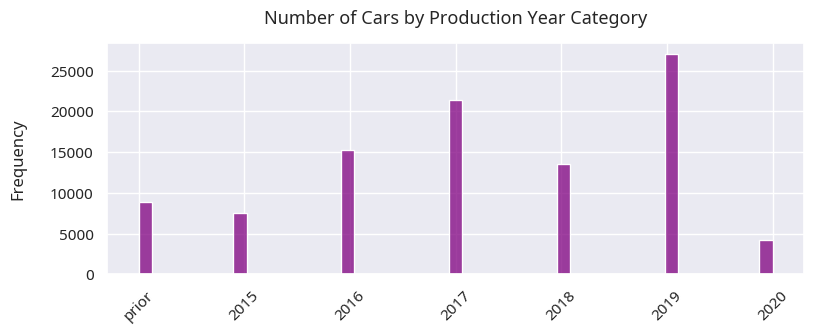

In [27]:
year_transformer = FunctionTransformer(lambda x: np.maximum(2014, x) - 2014)
year_tf = year_transformer.transform(df_train["year"])

plt.figure(figsize=(9, 3))

g = sns.histplot(year_tf, color="purple")
plt.xticks(np.arange(0,7), ["prior", 2015, 2016, 2017, 2018, 2019, 2020], rotation=45)
plt.title("Number of Cars by Production Year Category", y=1.05, **title_font)
plt.xlabel("")
plt.ylabel("Frequency\n")
plt.show()

Though it has not vanished entirely, the skew value has been diminished. A mild skew of this magnitude can be considered acceptable.

In [28]:
df_train["year"].skew(), year_tf.skew()

(-2.0564367422566527, -0.3638201002421604)

The year pipeline should also impute missing values and be scaled to a standard normal:

In [29]:
year_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("age", year_transformer),
    ("stdscl", StandardScaler()) 
])

### Fuel Efficiency

To mitigate skewness in the feature *mpg* which measures fuel efficiency, we proceed similarly.

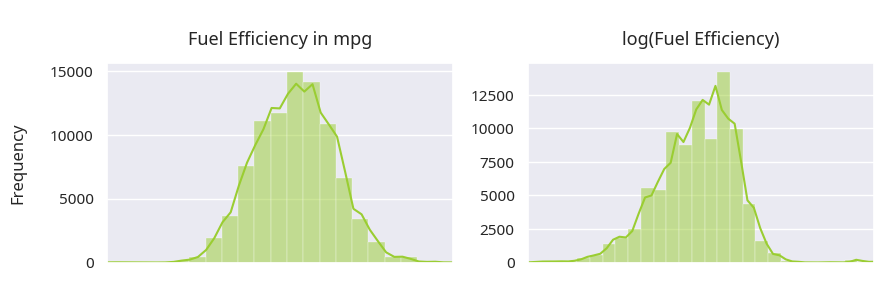

In [30]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
sns.histplot(df_train["mpg"], bins=100, kde=True, color="yellowgreen")
plt.title("\nFuel Efficiency in mpg", y=1.05, **title_font)
plt.xlabel("")
plt.xticks([])
plt.ylabel("Frequency\n")
plt.xlim(0,100)

plt.subplot(1, 2, 2)
sns.histplot(np.log(df_train["mpg"]), bins=100, kde=True, color="yellowgreen")
plt.title("\nlog(Fuel Efficiency)", y=1.05, **title_font)
plt.xlabel("")
plt.xticks([])
plt.ylabel("")
plt.xlim(3,5)

plt.tight_layout()
plt.show()

As we can see, the data is no longer skewed as much.

In [31]:
df_train["mpg"].skew(), np.log(df_train["mpg"]).skew()

(8.904272251528933, -0.3310270970415335)

We will simply use the *log_pipeline* we created before for the fuel efficiency feature.

### Road Tax and Engine Size

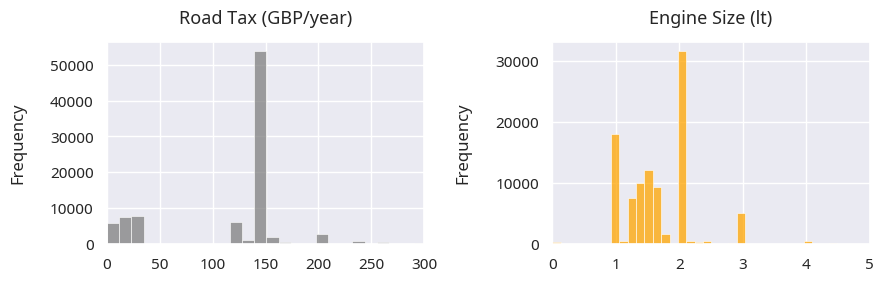

In [32]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
sns.histplot(df_train["tax"], bins=50, color="gray")
plt.title("Road Tax (GBP/year)", y=1.05, **title_font)
plt.xlabel("")
plt.xlim(0,300)
plt.ylabel("Frequency\n")

plt.subplot(1, 2, 2)
sns.histplot(df_train["engineSize"], bins=50, color="orange")
plt.title("Engine Size (lt)", y=1.05, **title_font)
plt.xlabel("")
plt.ylabel("Frequency\n")
plt.xticks(np.arange(0,6))
plt.xlim(0,5)

plt.tight_layout()
plt.show()

Looking at the graph for the road tax, we observe that the overwhelming majority of cars has a car tax of about 150 GBP. Furthermore, there are few cars that have a very low road tax between 0 and 50. Due to the fact that car prices are typically much higher than the amount of their corresponding road tax, the exact amount of the tax should not be too critical for the price of a used car. Hence we transform the road tax feature into a binary feature by grouping its values into the ranges of $[0, 50)$ and $[50, \infty)$.

In [33]:
#returns 1 if road tax is higher than 50 GBP and 0 otherwise
def tax_transformation(X):
    new_col = (X >= 50).astype(float)
    return pd.DataFrame(new_col, columns=["tax_tf"], index=df_train.index)

binary_transformer = FunctionTransformer(tax_transformation, validate=True)

In [34]:
tax_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="mean")),
    ("bin", binary_transformer) 
])

As we know from the quick correlation analysis at the beginning of this section, engine size is the most important numerical feature when it comes to predicting the price of a car. Its distribution is multimodal, with two peaks at $x = 1$ and $x = 2$. We can transform the feature by applying a radial basis function for each peak:

In [35]:
def rbf_kernel_func(X, Y, gamma):
    #the following two lines create an expressive feature name
    Y_float = float(Y[0][0])
    col_name = ["rbf" + str(Y)] #e.g. ["rbf2.0"]
    
    #computing the rbf similarity
    rbf_df = pd.DataFrame(rbf_kernel(X, Y, gamma=gamma).flatten(), 
                              index=df_train.index, columns=col_name)
    return rbf_df


We are creating two separate pipelines for the following reason. Our custom function expects a single-feature dataframe as an input *X*, and since we always need to pass the original *engineSize* feature, this would lead to problems after one new feature has been added to the frame.

In [36]:
engine_simil1 = FunctionTransformer(rbf_kernel_func, kw_args={"Y": [[1.]], "gamma": 2.77}, validate=True)
engine_simil2 = FunctionTransformer(rbf_kernel_func, kw_args={"Y": [[2.]], "gamma": 2.77}, validate=True)

engine_pipeline1 = Pipeline([
    ("imp", SimpleImputer(strategy="mean")),
    ("rbf1", engine_simil1),
    ("stdscl", StandardScaler()) 
])

engine_pipeline2 = Pipeline([
    ("imp", SimpleImputer(strategy="mean")),
    ("rbf1", engine_simil2),
    ("stdscl", StandardScaler()) 
])

How did we come up with this gamma value? Let us plot both rbf transformation functions:

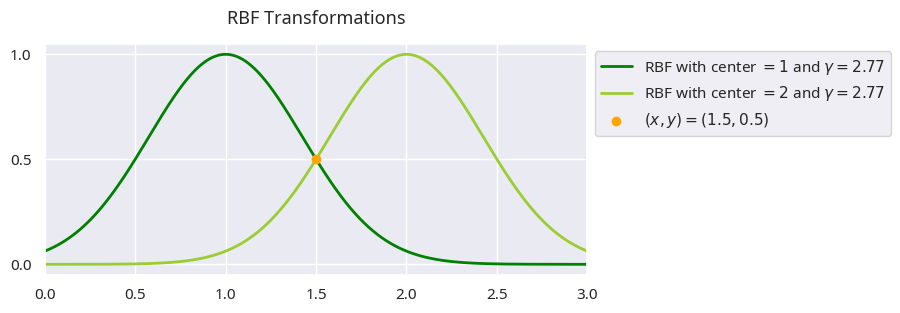

In [37]:
x = np.linspace(0, 3, 1000).reshape(-1,1)

rbf_values1 = rbf_kernel(x, [[1]], gamma=2.77) #scaled to match y-axis
rbf_values2 = rbf_kernel(x, [[2]], gamma=2.77) #scaled to match y-axis

plt.figure(figsize=(7,3))

plt.plot(x, rbf_values1, linewidth=2, color="green", label="RBF with center $= 1$ and $\\gamma = 2.77$")
plt.plot(x, rbf_values2, linewidth=2, color="yellowgreen", label="RBF with center $= 2$ and $\\gamma = 2.77$")
plt.scatter(1.5, 0.5, color="orange", zorder=2, label="$(x, y) = (1.5, 0.5)$")
plt.title("RBF Transformations", y=1.05, **title_font)
plt.xlabel("")
plt.ylabel("")
plt.legend(bbox_to_anchor=(1., 1.))
plt.yticks(np.linspace(0,1,3))
plt.xlim(0,3)
plt.show()

The green functions plotted are the RBF transformations with respective centers $x = 1$ and $x = 2$. The orange point in the graph at $x = 1.5$ indicates the height at which the RBF functions have a value of $y = 0.5$, i.e. half their maximum value. We now simply choose gamma such that the functions intersect this point.

Why? Remember that an RBF transformation is a similarity measure, reaching values from 1 at the center and approaching 0 far outwards. At the middle of our two centers, i.e. $x = 1.5$, we want both similarity measure functions to contribute the same value, as they are equally far apart from both modes. This is why we want them to intersect the orange point.

Mathematically, we solve for $\gamma$ in the equation $0.5 = \exp(-\gamma * (1 - 1.5)^2) = \exp(-0.25 \gamma)$:

In [38]:
np.log(0.5)/(-0.25)

2.772588722239781

<p> <br> </p>
<p> <br> </p>
<p> <br> </p>

__________________________
# 4. The Final Transformer

Let us put all transformations together into one single transformer.

In [39]:
preprocessing = ColumnTransformer([
    #converting tax values to categorical feature
    ("tax", tax_pipeline, ["tax"]),
    #converting engine size feature
    ("engine1", engine_pipeline1, ["engineSize"]),    
    ("engine2", engine_pipeline2, ["engineSize"]),    
    #converting and scaling year values
    ("age", year_pipeline, ["year"]),
    #converting mileage values to scaled mileage per year feature
    ("mileage", mileage_pipeline, ["mileage", "year"]),
    #converting values to scaled unskewed features
    ("log", log_pipeline, ["mpg", "price"]),
    #one-hot encoding categorical pipeline
    ("cat", onehot_pipeline, ["brand", "transmission", "fuelType"]),
    #transforming categorical model feature into scaled numerical feature
    ("model", model_pipeline, ["model", "price"]),
]).set_output(transform="pandas")

In [40]:
df_tf = preprocessing.fit_transform(df_train)
df_tf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97686 entries, 49125 to 14856
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   tax__tax_tf                  97686 non-null  float64
 1   engine1__rbf[[1.0]]          97686 non-null  float64
 2   engine2__rbf[[2.0]]          97686 non-null  float64
 3   age__year                    97686 non-null  float64
 4   mileage__mileage             97686 non-null  float64
 5   log__mpg                     97686 non-null  float64
 6   log__price                   97686 non-null  float64
 7   cat__brand_audi              97686 non-null  float64
 8   cat__brand_bmw               97686 non-null  float64
 9   cat__brand_cclass            97686 non-null  float64
 10  cat__brand_focus             97686 non-null  float64
 11  cat__brand_ford              97686 non-null  float64
 12  cat__brand_hyundi            97686 non-null  float64
 13  cat__brand_merc  

In [41]:
df_tf.describe().style.format("{:.2f}")

,tax__tax_tf,engine1__rbf[[1.0]],engine2__rbf[[2.0]],age__year,mileage__mileage,log__mpg,log__price,cat__brand_audi,cat__brand_bmw,cat__brand_cclass,cat__brand_focus,cat__brand_ford,cat__brand_hyundi,cat__brand_merc,cat__brand_skoda,cat__brand_toyota,cat__brand_vauxhall,cat__brand_vw,cat__transmission_Automatic,cat__transmission_Manual,cat__transmission_Other,cat__transmission_Semi-Auto,cat__fuelType_Diesel,cat__fuelType_Electric,cat__fuelType_Hybrid,cat__fuelType_Other,cat__fuelType_Petrol,model__model
count,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00,97686.00
mean,0.79,0.00,0.00,0.00,0.00,-0.00,0.00,0.10,0.10,0.04,0.05,0.17,0.04,0.12,0.06,0.06,0.12,0.14,0.21,0.57,0.00,0.23,0.42,0.00,0.03,0.00,0.55,-0.00
std,0.41,1.00,1.00,1.00,1.00,1.00,1.00,0.30,0.30,0.19,0.22,0.37,0.21,0.33,0.23,0.24,0.33,0.35,0.40,0.50,0.01,0.42,0.49,0.01,0.17,0.05,0.50,1.00
min,0.00,-1.17,-1.42,-1.92,-2.72,-22.58,-6.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.06
25%,1.00,-1.00,-1.14,-0.73,-0.59,-0.57,-0.68,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.80
50%,1.00,-0.19,-0.09,-0.14,0.06,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,-0.14
75%,1.00,1.21,1.23,1.04,0.64,0.58,0.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.62
max,1.00,1.49,1.23,1.64,7.57,9.45,4.50,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,11.76


Looks great! All features are scaled to the same numerical range and the data is now ready to be used for a Machine Learning algorithm. 

Finally, let us plot the correlation matrix for the new features:

[]

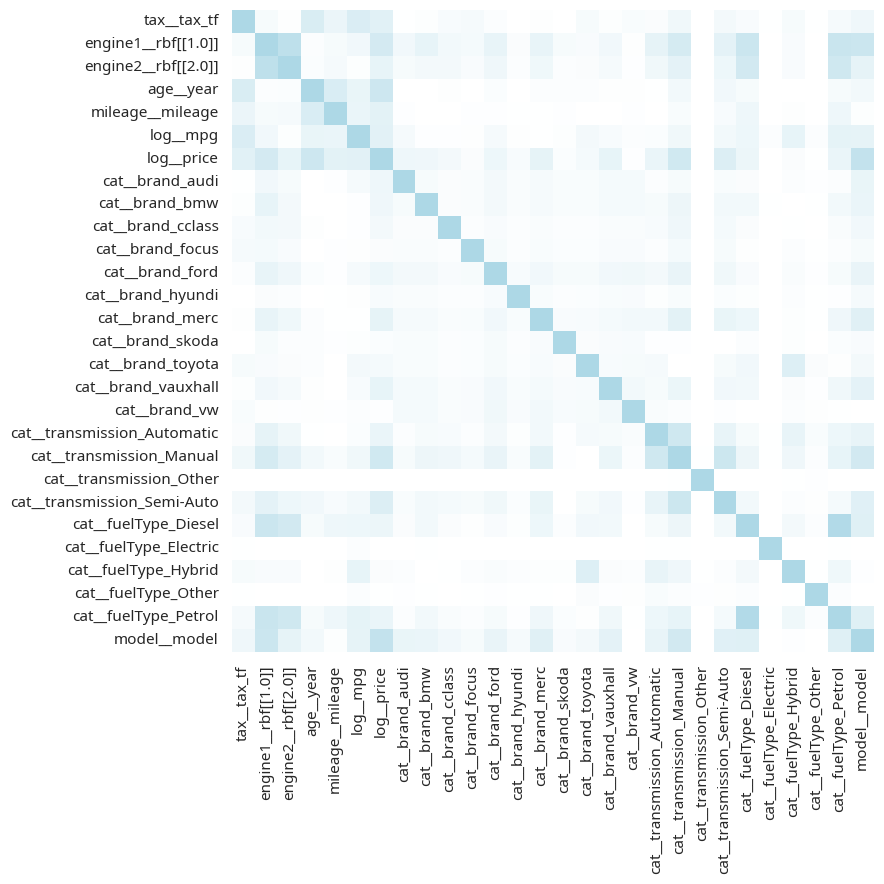

In [42]:
tf_corrmat = df_tf.corr()

plt.figure(figsize=(9,9))
sns.heatmap(tf_corrmat, annot=False, cmap=cmap, cbar=False, vmin=-1, vmax=1, center=0)
#plt.xticks([])
#plt.yticks([])

plt.tight_layout()
plt.plot()

In [43]:
tf_corrmat["log__price"].sort_values()

cat__transmission_Manual      -0.570192
engine1__rbf[[1.0]]           -0.527812
log__mpg                      -0.351373
mileage__mileage              -0.338373
cat__brand_vauxhall           -0.289584
cat__fuelType_Petrol          -0.253826
cat__brand_ford               -0.213048
cat__brand_toyota             -0.129147
cat__brand_hyundi             -0.099178
cat__brand_focus              -0.065681
cat__brand_skoda              -0.059667
cat__transmission_Other        0.000966
cat__fuelType_Electric         0.001734
cat__fuelType_Other            0.008625
cat__brand_vw                  0.022718
cat__fuelType_Hybrid           0.067850
cat__brand_cclass              0.148377
cat__brand_bmw                 0.201946
cat__brand_audi                0.207376
cat__fuelType_Diesel           0.231924
cat__transmission_Automatic    0.255897
engine2__rbf[[2.0]]            0.289548
cat__brand_merc                0.297038
tax__tax_tf                    0.363977
cat__transmission_Semi-Auto    0.426561


<p> <br> </p>
<p> <br> </p>
<p> <br> </p>

__________________________
## Export the data

Uncomment the following line to export the data frame to a local CSV file.

In [44]:
#df_tf.to_csv("all_cars_transformed.csv", header=True)